In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
dPath = Path("../docs/dumps")

In [3]:
with open(dPath / "test_set_data.pkl", 'rb') as filename:
    test_data = pickle.load(filename)

In [4]:
with open(dPath / "rf_exp_05_names.pkl", 'rb') as filename:
    names = pickle.load(filename)

In [5]:
X_test = []
y_test = []

In [6]:
for i in range(len(test_data)):
    test_data[i] = test_data[i][test_data[i].numExecuted > 0]
    X_test.append(test_data[i].drop("Detected", axis=1))
    y_test.append(test_data[i].Detected)
    X_test[i] = test_data[i][names]

In [7]:
with open(dPath / "mutclslabels.pkl", 'rb') as filename:
    mutclslabels = pickle.load(filename)

In [8]:
with open(dPath / "retypelabels.pkl", 'rb') as filename:
    retypelabels = pickle.load(filename)

In [9]:
mutclscodes = dict(zip(mutclslabels,range(len(mutclslabels))))

In [10]:
retypecodes = dict(zip(retypelabels,range(len(retypelabels))))

In [11]:
for i in range(len(test_data)):
    X_test[i].replace(mutclscodes, inplace=True)
    X_test[i].replace(retypecodes, inplace=True)

In [12]:
with open(dPath / "hgb_exp_02_stacking.pkl", 'rb') as filename:
    hgbs = pickle.load(filename)

In [13]:
with open(dPath / "rf_exp_08.pkl", 'rb') as filename:
    rf = pickle.load(filename)

In [14]:
rm_indices = []
for i in range(len(X_test)):
    if X_test[i].shape[0] <= 10:
        rm_indices.append(i)

In [15]:
X_test = [i for j, i in enumerate(X_test) if j not in rm_indices]

In [16]:
y_test = [i for j, i in enumerate(y_test) if j not in rm_indices]

In [17]:
hgbs_preds = []
for i in range(len(X_test)):
    predictions = []
    for _model in hgbs:
        predictions.append(_model.predict_proba(X_test[i])[:,1])
    hgbs_preds_test = np.vstack(predictions).T
    hgbs_preds.append(hgbs_preds_test.mean(axis=1))

In [18]:
rf_preds = []
for i in range(len(X_test)):  
    X_test[i]['ExecutedRatio'] = np.log(X_test[i].numExecuted)/X_test[i].ppnumberOfStatements
    rf_preds.append(rf.predict_proba(X_test[i])[:,1])

In [19]:
for i in range(len(X_test)):
    print(rf_preds[i].shape,hgbs_preds[i].shape)

(133,) (133,)
(809,) (809,)
(364,) (364,)
(4506,) (4506,)
(21,) (21,)
(128,) (128,)
(337,) (337,)
(112,) (112,)
(349,) (349,)
(4697,) (4697,)
(406,) (406,)
(861,) (861,)
(3869,) (3869,)
(542,) (542,)
(2033,) (2033,)
(54,) (54,)
(691,) (691,)
(287,) (287,)
(1301,) (1301,)
(33,) (33,)
(100,) (100,)
(261,) (261,)
(1943,) (1943,)
(29,) (29,)
(238,) (238,)
(153,) (153,)
(773,) (773,)
(37,) (37,)
(248,) (248,)
(982,) (982,)
(4736,) (4736,)
(749,) (749,)
(1531,) (1531,)
(104,) (104,)
(169,) (169,)
(426,) (426,)
(2246,) (2246,)
(522,) (522,)
(33,) (33,)
(543,) (543,)
(102,) (102,)
(1475,) (1475,)
(514,) (514,)
(106,) (106,)
(2414,) (2414,)
(46,) (46,)
(213,) (213,)
(3254,) (3254,)
(43,) (43,)
(3551,) (3551,)
(188,) (188,)
(835,) (835,)
(179,) (179,)
(3851,) (3851,)
(690,) (690,)
(579,) (579,)
(1484,) (1484,)
(173,) (173,)
(296,) (296,)
(162,) (162,)
(600,) (600,)
(89,) (89,)
(266,) (266,)


In [20]:
balanced_accuracy_scores = []
matthews_corrcoef_scores = []
average_precision_scores = []
roc_auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
log_losses = []
zero_one_loss = []
for i in range(len(rf_preds)):  
    try:
        balanced_accuracy_scores.append(metrics.balanced_accuracy_score(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5, adjusted=True))
        matthews_corrcoef_scores.append(metrics.matthews_corrcoef(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5))
        average_precision_scores.append(metrics.average_precision_score(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >=0.5))
        roc_auc_scores.append(metrics.roc_auc_score(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >=0.5))
        precision_scores.append(metrics.precision_score(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5))
        recall_scores.append(metrics.recall_score(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5))
        f1_scores.append(metrics.f1_score(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5))
        log_losses.append(metrics.log_loss(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5))
        zero_one_loss.append(metrics.zero_one_loss(y_test[i], (rf_preds[i] + hgbs_preds[i])/2 >= 0.5))
    except:
        pass

In [21]:
import matplotlib.pyplot as plt

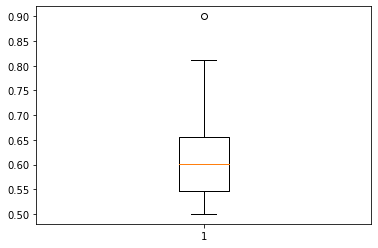

In [22]:
plt.boxplot(np.array(roc_auc_scores));

In [23]:
np.average(roc_auc_scores)

0.6140719426374064

In [24]:
np.median(roc_auc_scores)

0.6010721817088899

In [25]:
df = pd.DataFrame([balanced_accuracy_scores,matthews_corrcoef_scores,average_precision_scores,roc_auc_scores,precision_scores,recall_scores,f1_scores,log_losses,zero_one_loss]).T

In [26]:
df.columns = ['balanced_accuracy_scores','matthews_corrcoef_scores','average_precision_scores','roc_auc_scores','precision_scores','recall_scores','f1_scores','log_losses','zero_one_loss']

In [27]:
df.to_excel(dPath / "stacking_evaluation.xlsx")